In [ ]:
# --- Dependencies ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Optional, Union

def run_progress_scoring(

    data: Union[dict, pd.DataFrame],
    static_weights: Dict[str, float] = None,
    alpha: float = 0.4,
    plot: bool = True,
    save_plot_path: Optional[str] = None,
    ax: Optional[plt.Axes] = None,
    always_up: bool = False, # Added comma here
) -> Tuple[pd.DataFrame, Dict[str, float], Dict[str, float]]:
    """
    Run your entropy→hybrid weighting → scoring → cumulative pipeline on a single table.

    Parameters
    ----------
    data : dict or pd.DataFrame
        Table with columns: Compare, Objectives, Architecture, Dataset, Application, Impact, Speed.
        Values are +1/-1/0/'Null'/None.
    static_weights : dict, optional
        Must sum to ~1. Default matches your config.
    alpha : float, default=0.4
        Hybrid mixing parameter: 0=static only, 1=dynamic only.
    plot : bool, default=True
        If True, plot credible & always-up curves.
    save_plot_path : str or None
        If provided, saves the plot to this path.
    ax : matplotlib.axes.Axes or None
        If provided, draws on this Axes; otherwise creates a new figure.
    credible, upward = credible_and_upward(scores, always_up=always_up)

    Returns
    -------
    out : pd.DataFrame
        Per-interval results with columns: Score, Cumulative (credible), Cumulative (always-up)
    dyn_w : dict
        Dynamic (entropy) weights
    hyb_w : dict
        Hybrid weights (blended with alpha)
    """
    # -------------------------
    # Defaults
    # -------------------------
    if static_weights is None:
        static_weights = {
            "Objectives": 0.20,
            "Architecture": 0.20,
            "Dataset": 0.15,
            "Application": 0.15,
            "Impact": 0.15,
            "Speed": 0.15,
        }

    # -------------------------
    # Helpers (scoped)
    # -------------------------
    def normalize_weights(d: Dict[str, float]) -> Dict[str, float]:
        arr = np.array(list(d.values()), dtype=float)
        s = arr.sum()
        if s != 0:
            arr = arr / s
        return dict(zip(d.keys(), arr))

    def entropy_dynamic_weights(df_vals: pd.DataFrame, ignore_null: bool = True) -> Dict[str, float]:
        M = df_vals.copy().replace("Null", np.nan)
        # numeric (NaN for Null)
        for c in M.columns:
            M[c] = pd.to_numeric(M[c], errors="coerce")
        absM = M.abs()

        cols = absM.columns
        n_rows = len(absM)

        P = np.zeros_like(absM.values, dtype=float)
        for j, col in enumerate(cols):
            col_vals = absM[col].values
            if ignore_null:
                mask = ~np.isnan(col_vals)
                denom = col_vals[mask].sum()
                if denom == 0 or mask.sum() == 0:
                    continue
                P[mask, j] = col_vals[mask] / denom
            else:
                col_vals = np.nan_to_num(col_vals, nan=0.0)
                denom = col_vals.sum()
                P[:, j] = (col_vals / denom) if denom != 0 else (np.ones(n_rows) / max(n_rows, 1))

        eps = 1e-12
        H = np.zeros(len(cols), dtype=float)
        for j in range(len(cols)):
            pj = P[:, j]
            used = pj > 0
            m = int(used.sum())
            if m == 0:
                H[j] = 1.0
            else:
                Hj = -(pj[used] * np.log(pj[used] + eps)).sum() / np.log(m)
                H[j] = float(np.clip(Hj, 0.0, 1.0))

        U = 1.0 - H
        W = U / U.sum() if U.sum() > 0 else np.ones_like(U) / len(U)
        return dict(zip(cols, W))

    def hybrid_weights(static_w: Dict[str, float], dynamic_w: Dict[str, float], alpha: float = 0.4) -> Dict[str, float]:
        keys = list(static_w.keys())
        hyb = {k: (1 - alpha) * static_w[k] + alpha * dynamic_w.get(k, 0.0) for k in keys}
        return normalize_weights(hyb)

    def row_scores(df_signed: pd.DataFrame, weights: Dict[str, float]) -> pd.Series:
        D = df_signed.replace("Null", np.nan).copy()
        for c in D.columns:
            D[c] = pd.to_numeric(D[c], errors="coerce")
        W = pd.Series(weights)
        return (D * W).sum(axis=1, skipna=True)

    def credible_and_upward(series: pd.Series, always_up: bool = False) -> tuple[pd.Series, pd.Series]:
      C = series.cumsum()
      G = C.cummax() if always_up else C.copy()  # <- no flattening when False
      return C, G

    # -------------------------
    # Prepare input
    # -------------------------
    df = pd.DataFrame(data) if isinstance(data, dict) else data.copy()
    df = df.set_index("Compare")
    value_cols = list(static_weights.keys())

    # -------------------------
    # Compute weights & scores
    # -------------------------
    dyn_w = entropy_dynamic_weights(df[value_cols], ignore_null=True)
    hyb_w = hybrid_weights(static_weights, dyn_w, alpha=alpha)
    scores = row_scores(df[value_cols], hyb_w)
    credible, upward = credible_and_upward(scores, always_up=always_up) # Pass always_up here

    out = pd.DataFrame({
        "Score": scores.round(3),
        "Cumulative (credible)": credible.round(3),
        "Cumulative (always-up)": upward.round(3),
    }, index=df.index)

    # -------------------------
    # Optional plot
    # -------------------------
    if plot:
        if ax is None:
            plt.figure(figsize=(9, 5))
            ax = plt.gca()
            owns_ax = True
        else:
            owns_ax = False

        ax.plot(out.index, out["Cumulative (credible)"], marker='o', label="Credible (net)")
        ax.plot(out.index, out["Cumulative (always-up)"], marker='o', linestyle='--', label="Always-up (cummax)")
        ax.set_xticklabels(out.index, rotation=45)
        ax.set_xlabel("Interval")
        ax.set_ylabel("Cumulative Score")
        ax.set_title("Hybrid-weight Progression (0→0, Null ignored)")
        ax.grid(True)
        ax.legend()
        if save_plot_path:
            fig = ax.get_figure()
            fig.tight_layout()
            fig.savefig(save_plot_path, dpi=150)
        if owns_ax:
            plt.tight_layout()
            plt.show()

    return out, dyn_w, hyb_w

#-----------------------------------------------------------------------------------------------------------------------------------


def plot_final_combined_graph(
    all_paths,
    static_weights=None,
    alpha=0.4,
    show_individual=True,
    save_path=None,
):
    """
    Aggregate 20 (or N) Excel files into one final combined graph.
    - all_paths: list of Excel file paths you uploaded (e.g., '/content/file.xlsx')
    - static_weights: dict of static weights (sum ~ 1). If None, uses your defaults.
    - alpha: hybrid mix parameter for run_progress_scoring
    - show_individual: overlay faint individual cumulative curves for transparency
    - save_path: optional filename to save the figure

    Returns
    -------
    aggregate_df : pd.DataFrame
        Step-wise mean/median/p25/p75/std for Cumulative and Upward
    finals_df : pd.DataFrame
        Final net & upward per file
    per_set_outputs : dict[str, pd.DataFrame]
        Per-interval results for each file (Score, Cumulative, Upward)
    """
    if static_weights is None:
        static_weights = {
            "Objectives": 0.20, "Architecture": 0.20, "Dataset": 0.15,
            "Application": 0.15, "Impact": 0.15, "Speed": 0.15
        }

    # 1) Run your existing pipeline on each file
    per_set_outputs = {}
    for path in all_paths:
        df = pd.read_excel(path)
        out, _, _ = run_progress_scoring(
            df,
            static_weights=static_weights,
            alpha=alpha,
            plot=False
        )
        per_set_outputs[path] = out

    # 2) Aggregate by step index (handles different interval labels/lengths)
    max_len = max(len(out) for out in per_set_outputs.values())
    cum_mat = np.full((len(per_set_outputs), max_len), np.nan)
    up_mat  = np.full((len(per_set_outputs), max_len), np.nan)

    for r, (_, out) in enumerate(per_set_outputs.items()):
        cvals = out["Cumulative (credible)"].values.astype(float)
        uvals = out["Cumulative (always-up)"].values.astype(float)
        cum_mat[r, :len(cvals)] = cvals
        up_mat[r,  :len(uvals)] = uvals

    step = np.arange(1, max_len + 1)

    def stats(M):
        mean   = np.nanmean(M, axis=0)
        median = np.nanmedian(M, axis=0)
        p25    = np.nanpercentile(M, 25, axis=0)
        p75    = np.nanpercentile(M, 75, axis=0)
        std    = np.nanstd(M, axis=0, ddof=1)
        return mean, median, p25, p75, std

    C_mean, C_median, C_p25, C_p75, C_std = stats(cum_mat)
    G_mean, G_median, G_p25, G_p75, G_std = stats(up_mat)

    aggregate_df = pd.DataFrame({
        "Step": step,
        "Cumulative_mean": C_mean,
        "Cumulative_median": C_median,
        "Cumulative_p25": C_p25,
        "Cumulative_p75": C_p75,
        "Cumulative_std": C_std,
        "Upward_mean": G_mean,
        "Upward_median": G_median,
        "Upward_p25": G_p25,
        "Upward_p75": G_p75,
        "Upward_std": G_std,
    })

    # 3) Final-point metrics per file
    finals_net = []
    finals_up  = []
    for path, out in per_set_outputs.items():
        finals_net.append(float(out["Cumulative (credible)"].iloc[-1]))
        finals_up.append(float(out["Cumulative (always-up)"].iloc[-1]))
    finals_df = pd.DataFrame({
        "file": list(per_set_outputs.keys()),
        "final_net": finals_net,
        "final_upward": finals_up
    })

    # 4) Plot final combined graph (mean + IQR bands), optional individual overlays
    plt.figure(figsize=(10, 6))

    # Net cumulative (mean + IQR)
    plt.plot(aggregate_df["Step"], aggregate_df["Cumulative_mean"], marker='o', label="Net cumulative (mean)")
    plt.fill_between(
        aggregate_df["Step"],
        aggregate_df["Cumulative_p25"],
        aggregate_df["Cumulative_p75"],
        alpha=0.20,
        label="Net cumulative IQR (25–75%)"
    )

    # Upward cumulative (mean + IQR)
    plt.plot(aggregate_df["Step"], aggregate_df["Upward_mean"], marker='o', linestyle='--', label="Upward cumulative (mean)")
    plt.fill_between(
        aggregate_df["Step"],
        aggregate_df["Upward_p25"],
        aggregate_df["Upward_p75"],
        alpha=0.20,
        label="Upward IQR (25–75%)"
    )

    # Optional: faint individual curves for credibility
    if show_individual:
        for _, out in per_set_outputs.items():
            y = out["Cumulative (credible)"].values.astype(float)
            plt.plot(range(1, len(y) + 1), y, alpha=0.15, linewidth=1)

    plt.xlabel("Step")
    plt.ylabel("Cumulative Score")
    plt.title("FINAL Combined Progress — Mean with IQR (across all files)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

    # 5) Print quick summary
    print("Summary of final points across files:")
    print(finals_df.describe(include="all"))

    return aggregate_df, finals_df, per_set_outputs

/tmp/ipython-input-700456254.py:102: RuntimeWarning: divide by zero encountered in scalar divide
  Hj = -(pj[used] * np.log(pj[used] + eps)).sum() / np.log(m)
/tmp/ipython-input-700456254.py:70: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  M = df_vals.copy().replace("Null", np.nan)
/tmp/ipython-input-700456254.py:102: RuntimeWarning: divide by zero encountered in scalar divide
  Hj = -(pj[used] * np.log(pj[used] + eps)).sum() / np.log(m)
/tmp/ipython-input-700456254.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  D = df_sig

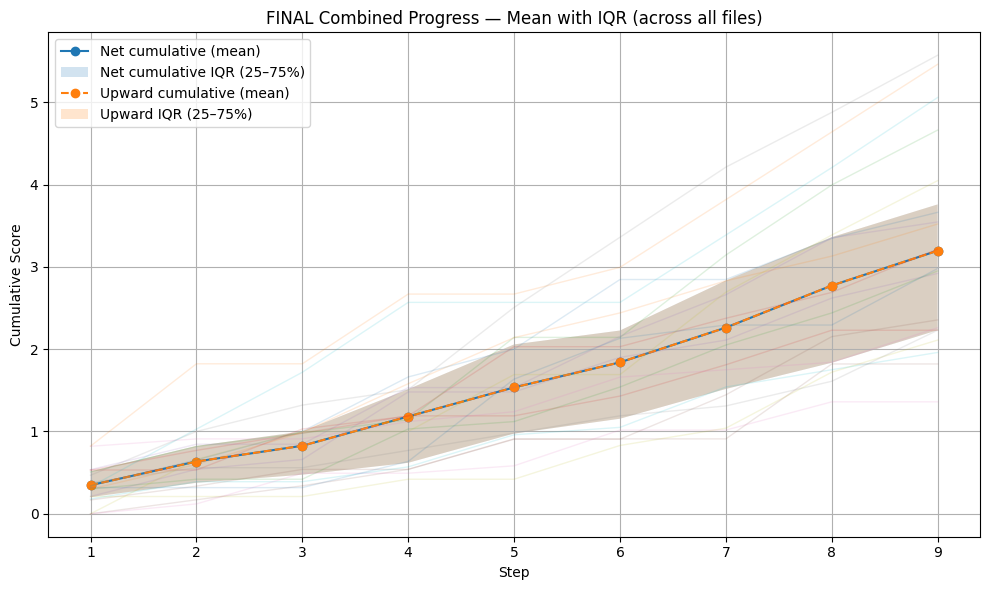

Summary of final points across files:
                                           file  final_net  final_upward
count                                        20  20.000000     20.000000
unique                                       20        NaN           NaN
top     /content/value_Algorithm Optimizer.xlsx        NaN           NaN
freq                                          1        NaN           NaN
mean                                        NaN   3.195700      3.195700
std                                         NaN   1.238507      1.238507
min                                         NaN   1.360000      1.360000
25%                                         NaN   2.230000      2.230000
50%                                         NaN   2.965000      2.965000
75%                                         NaN   3.758250      3.758250
max                                         NaN   5.570000      5.570000


In [ ]:
 import pandas as pd

# Manually list the Excel files you uploaded
all_paths = [
    "/content/value_Algorithm Optimizer.xlsx",
    "/content/value_Audio Analyzation.xlsx",
    "/content/value_Audio Emotion Recognition.xlsx",
    "/content/value_Blockchain.xlsx",
    "/content/value_Chatbot.xlsx",
    "/content/value_Code Generation.xlsx",
    "/content/value_Explainable AI.xlsx",
    "/content/value_Green Chemistry.xlsx",
    "/content/value_Hate Speech.xlsx",
    "/content/value_Heat Transfer.xlsx",
    "/content/value_Image Caption.xlsx",
    "/content/value_Log Anomaly Detection.xlsx",
    "/content/value_Multi Hazard Vulnerability Assessment.xlsx",
    "/content/value_Neutron Stars and Pulsar Timing.xlsx",
    "/content/value_Protein Structure.xlsx",
    "/content/value_Quantum Entanglement and Information Processing.xlsx",
    "/content/value_Robotics.xlsx",
    "/content/value_Sentiment Analysis.xlsx",
    "/content/value_Text Summarization.xlsx",
    "/content/value_Violence Detection.xlsx",

    # ... add the rest as you upload them
]

finals = []
all_outputs = {}

for path in all_paths:
    df = pd.read_excel(path)   # read Excel file

    out, dyn_w, hyb_w = run_progress_scoring(
        df,
        static_weights={
            "Objectives": 0.27, "Architecture": 0.23, "Dataset": 0.15,
            "Application": 0.15, "Impact": 0.15, "Speed": 0.15
        },
        alpha=0.4,
        plot=False   # disable per-file plotting
    )

    all_outputs[path] = out
    finals.append(out["Cumulative (credible)"].iloc[-1])

summary = pd.DataFrame({
    "file": list(all_outputs.keys()),
    "final_net": finals
})
#print(summary)

# =====================
# 👉 Call the combined plot here
# =====================
aggregate_df, finals_df, per_set_outputs = plot_final_combined_graph(
    all_paths,
    alpha=0.4,
    show_individual=True,           # overlay faint individual curves
    save_path="final_combined.png"  # optional
)
